# Example Pipeline for a Markov State Model for CDP1

## Import functions

In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import mdtraj
import pyemma
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt
from pyemma.util.contexts import settings
from itertools import product
import subprocess as sbp

## Load Trajetories and interal features

In [3]:
#Reihenfolgen: Phi 2-10, 1 & Psi 1-10
def make_phi_psi_indices(topology):
   
    '''
    Function that extracts the phi and psi angles of cyclic peptides (also including the ring closure)
    '''
    
    indices = list(topology.select("name N or name C or name CA"))

    psi = indices + [indices[0]]
    phi = indices[2 : ] + indices[ : 2]
    phi = phi + [phi[0]]
    psi = [psi[i : i + 4] for i in range(0, len(psi), 3)][:-1]
    phi = [phi[i : i + 4] for i in range(0, len(phi), 3)][:-1]
    return phi, psi

In [5]:
topfile = 'path_to_topfile'
feat = pyemma.coordinates.featurizer(topfile)
h5_trajs = 'list_containing_paths_to_trajectories'

In [8]:
phi,psi = make_phi_psi_indices(feat)
feat.add_dihedrals(phi + psi,cossin=True, periodic=False)
torsions_data = pyemma.coordinates.load(h5_trajs, features=feat)

100%|██████████| 120/120 [00:02<00:00, 44.38it/s]                                 


In [9]:
inp = coor.source(h5_trajs, feat)
print('number of trajectories = ',inp.number_of_trajectories())
print('trajectory length = ',inp.trajectory_length(0),inp.trajectory_length(112)) #one is a long, the other a short trajectory
print('number of dimension = ',inp.dimension())
print('trajectory time step = ',0.002 * 5000*10 ,'ps')


100%|██████████| 120/120 [00:00<00:00, 420.67it/s]                    

number of trajectories =  120
trajectory length =  1000 200
number of dimension =  40
trajectory time step =  100.0 ps


## Load External Features

In [10]:
def add_data(old_entries,old_data,dir_new_data):
    
    '''
    Function that adds the data read in by the external feature files to the internal features 
    '''
    
    n = 0
    all_data = []
    for entry in old_entries:
        frame = pd.read_csv(dir_new_data+entry)
        data_new = frame.values
        data_old = old_data[n]
        data_combined = np.concatenate((data_old, data_new), axis=1)
        all_data.append(data_combined)
        n += 1
    return(all_data)

In [11]:
angle_dir = 'path_to_orientation_files'
pos_dir = 'path_to_position_files'

#add external features to the Matrix already containing the internal features 
torsions_angles_data = add_data(h5_trajs,torsions_data,angle_dir)
torsions_angles_pos_data = add_data(h5_trajs,torsions_angles_data,pos_dir)

## TICA

In [12]:
# Make a TICA analysis 
tica = coor.tica(torsions_angles_pos_data, lag=10, var_cutoff=0.95, kinetic_map=True)
print('TICA dimension ', tica.dimension())
tica_output = tica.get_output() # get tica coordinates
tica_concatenated = np.concatenate(tica_output) # combine all trajectories 


100%|██████████| 120/120 [00:00<00:00, 2900.07it/s]            

TICA dimension  6


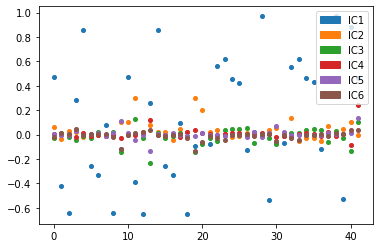

In [14]:
plt.plot(tica.feature_TIC_correlation,'o',markersize=4)
IC1_col = mpatches.Patch(color='C0', label='IC1')
IC2_col = mpatches.Patch(color='C1', label='IC2')
IC3_col = mpatches.Patch(color='C2', label='IC3')
IC4_col = mpatches.Patch(color='C3', label='IC4')
IC5_col = mpatches.Patch(color='C4', label='IC5')
IC6_col = mpatches.Patch(color='C5', label='IC6')
plt.legend(handles=[IC1_col,IC2_col,IC3_col,IC4_col,IC5_col,IC6_col])

## Sittel-Stock Clustering

In [ ]:
'''
# python script to run sittel-stock clustering in the shell
# more infromation can be found here: https://moldyn.github.io/Clustering/docTutorial.html

#defines where temporary files are written to
working_dir = 'path_to_working_dir'
traj_name = working_dir + 'microstates'

#perform density and energy estimation
command_states = ['clustering', 'density', '-f', data_tica, '-T', '-1', '-d', 'fe', '-b', 'nn', '-o', 'cluster','-v']
p1 = sbp.Popen(command_states, stdout=sbp.PIPE, cwd=working_dir)
#wait for the process to finish
p1.wait()
'''

In [38]:
'''
#screen for best min_population_parameter
number_states_list = []
param_list = [1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000]
for param in param_list:
    #set parameters
    min_population = str(param) # minimal number of members fo a cluster
    
    #create network
    command_network = ['clustering', 'network', '-p', min_population ,'--network-html', '--basename' ,'cluster' , '-o',  'network' ,'-v']
    p2 = sbp.Popen(command_network, stdout=sbp.PIPE, cwd=working_dir)
    #wait for the process to finish
    p2.wait()
    
    #create dtraj
    command_microstate = ['clustering', 'density', '-f', data_tica, '-i', 'network_end_node_traj.dat', '-D', 'fe', '-B', 'nn', '-o', 'microstates', '-v']
    p3 = sbp.Popen(command_microstate, stdout=sbp.PIPE, cwd=working_dir)
    #wait for the process to finish
    p3.wait()

    # read in the discretized trajectory
    dtraj = pd.read_csv(traj_name,skiprows=19)
    #get number of states
    number_states = len(set(dtraj[dtraj.columns[0]]))
    number_states_list.append(number_states)
'''

Text(0.5, 0, 'p_min')

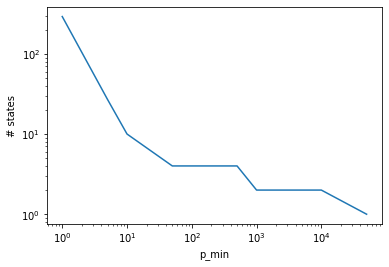

In [39]:
'''
# plot states vs min population parameter
plt.plot(param_list, number_states_list)

plt.yscale('log')
plt.ylabel('# states')
plt.xscale('log')
plt.xlabel('p_min')
'''

In [40]:
# perform clustering with optimal p_min choice
'''
param_opt = 100   
#set parameters
min_population = str(param_opt) # minimal number of members fo a cluster
    
#create network
command_network = ['clustering', 'network', '-p', min_population ,'--network-html', '--basename' ,'cluster' , '-o',  'network' ,'-v']
p2 = sbp.Popen(command_network, stdout=sbp.PIPE, cwd=working_dir)
#wait for the process to finish
p2.wait()
    
#create dtraj
command_microstate = ['clustering', 'density', '-f', data_tica, '-i', 'network_end_node_traj.dat', '-D', 'fe', '-B', 'nn', '-o', 'microstates', '-v']
p3 = sbp.Popen(command_microstate, stdout=sbp.PIPE, cwd=working_dir)
#wait for the process to finish
p3.wait()

'''

In [18]:
# Split the dtraj back into the individual simulations to avoid pseudo-transitions

dtraj = pd.read_csv(traj_name,skiprows=19)
    
cluster = []
frame_counter = 0
dtraj_pure = dtraj[dtraj.columns[0]].values
#go through all trajectories and get their length
for sub_traj in tica_output:       
    len_curr_traj = sub_traj.shape[0]
    cluster.append(dtraj_pure[frame_counter:frame_counter+len_curr_traj])
    frame_counter += len_curr_traj
    

## MSM estimation and validation

### Implied timescales

In [48]:
# remove the fist 2 ns for equilibration
def equilibrate(discrete_traj):
    new_discrete_traj = []
    for entry in discrete_traj:
        cutted_entry = entry[20:]
        new_discrete_traj.append(cutted_entry)
    return new_discrete_traj

def equilibrate_tica(tica_out):
    new_tica = []
    for entry in tica_out:
        cutted_entry = entry[20:,:]
        new_tica.append(cutted_entry)
    return new_tica
        
new_cluster = equilibrate(cluster)
new_tica_out = equilibrate_tica(tica_output)
new_tica_concatenated = np.concatenate(new_tica_out) # combine all trajectories


100%|██████████| 10/10 [00:01<00:00,  5.70it/s]                       

20-08-21 13:23:54 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[4] WARNING  Changed user setting nits to the number of available timescales nits=3


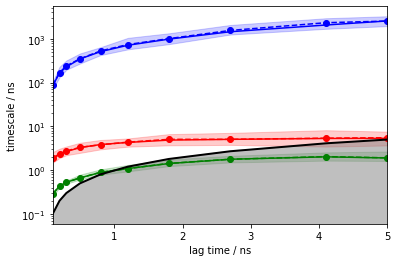

In [27]:
# test the discretized data
its = pyemma.msm.its(new_cluster, lags=50, nits=4, errors='bayes')
dtrajs_active_concatenated = np.concatenate(msm.dtrajs_active)
pyemma.plots.plot_implied_timescales(its, units='ns', dt=0.1);


In [29]:
msm = pyemma.msm.bayesian_markov_model(new_cluster, lag=15, dt_traj='0.1 ns')
print('fraction of states used = {:.2f}'.format(msm.active_state_fraction))
print('fraction of counts used = {:.2f}'.format(msm.active_count_fraction))

100%|██████████| 100/100 [00:00<00:00, 11439.84it/s]                                                     

fraction of states used = 0.80
fraction of counts used = 1.00


### Chapman-Kolmogorov test

100%|██████████| 5/5 [00:01<00:00,  3.27it/s]                        


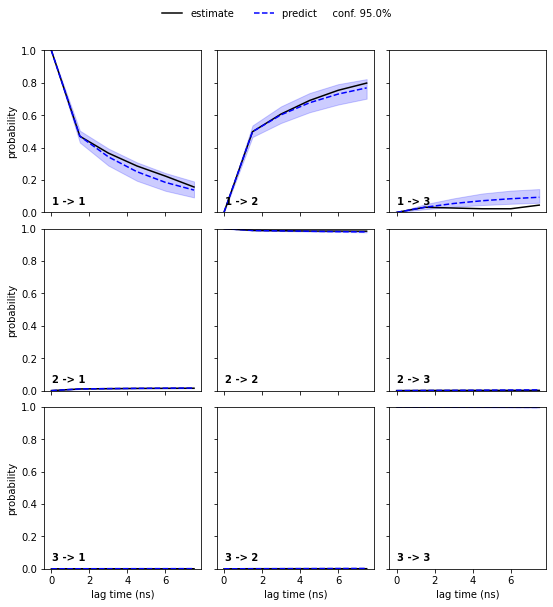

In [32]:
nstates = 3 
cktest = msm.cktest(nstates, mlags=6)
pyemma.plots.plot_cktest(cktest, dt=0.1, units='ns');

### MSM spectral analysis

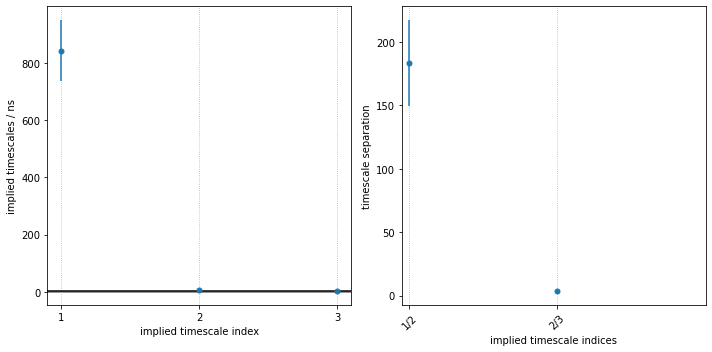

In [33]:
def its_separation_err(ts, ts_err):
    """
    Error propagation from ITS standard deviation to timescale separation.
    """
    return ts[:-1] / ts[1:] * np.sqrt(
        (ts_err[:-1] / ts[:-1])**2 + (ts_err[1:] / ts[1:])**2)

nits = 3

timescales_mean = msm.sample_mean('timescales', k=nits)
timescales_std = msm.sample_std('timescales', k=nits)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].errorbar(
    range(1, nits + 1),
    timescales_mean,
    yerr=timescales_std,
    fmt='.', markersize=10)
axes[1].errorbar(
    range(1, nits),
    timescales_mean[:-1] / timescales_mean[1:],
    yerr=its_separation_err(
        timescales_mean,
        timescales_std),
    fmt='.',
    markersize=10,
    color='C0')

for i, ax in enumerate(axes):
    ax.set_xticks(range(1, nits + 1))
    ax.grid(True, axis='x', linestyle=':')

axes[0].axhline(msm.lag * 0.1, lw=1.5, color='k')
axes[0].axhspan(0, msm.lag * 0.1, alpha=0.3, color='k')
axes[0].set_xlabel('implied timescale index')
axes[0].set_ylabel('implied timescales / ns')
axes[1].set_xticks(range(1, nits))
axes[1].set_xticklabels(
    ["{:d}/{:d}".format(k, k + 1) for k in range(1, nits
                                                )],
    rotation=45)
axes[1].set_xlabel('implied timescale indices')
axes[1].set_ylabel('timescale separation')
fig.tight_layout()

In [34]:
for nit in range(nits):
    print(round(timescales_mean[nit],1)," \u00B1 ",round(timescales_std[nit],1)," ns")

842.8  ±  106.8  ns
4.6  ±  0.6  ns
1.3  ±  0.1  ns


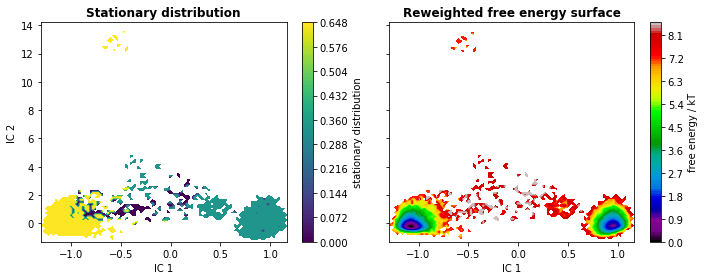

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
pyemma.plots.plot_contour(
    *new_tica_concatenated[:, :2].T,
    msm.pi[dtrajs_active_concatenated],
    ax=axes[0],
    mask=True,
    cbar_label='stationary distribution')
pyemma.plots.plot_free_energy(
    *new_tica_concatenated[:, :2].T,
    weights=np.concatenate(msm.trajectory_weights()),
    ax=axes[1],
    legacy=False)
for ax in axes.flat:
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
axes[0].set_title('Stationary distribution', fontweight='bold')
axes[1].set_title('Reweighted free energy surface', fontweight='bold')
fig.tight_layout()

The first eigenvector is one: True (min=0.9999999999995931, max=1.0000000000002225)


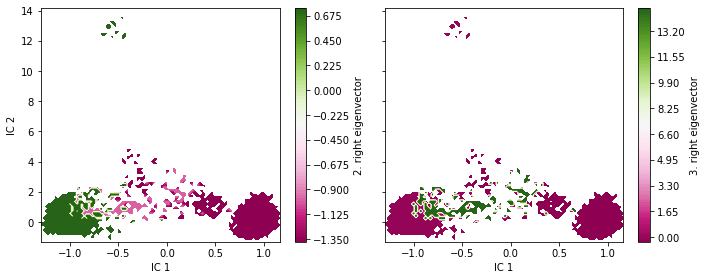

In [54]:
eigvec = msm.eigenvectors_right()
print('The first eigenvector is one: {} (min={}, max={})'.format(
    np.allclose(eigvec[:, 0], 1, atol=1e-15), eigvec[:, 0].min(), eigvec[:, 0].max()))

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *new_tica_concatenated[:, :2].T,
        eigvec[dtrajs_active_concatenated, i + 1],
        ax=ax,
        cmap='PiYG',
        cbar_label='{}. right eigenvector'.format(i + 2),
        mask=True)
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
fig.tight_layout()

### Perron cluster cluster analysis

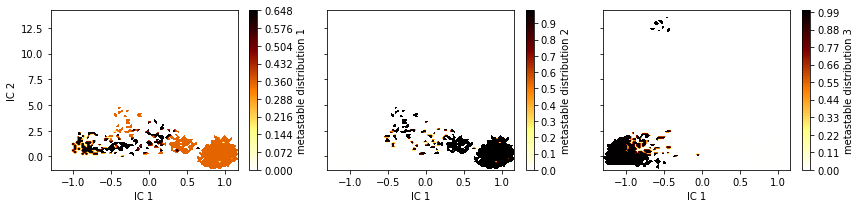

In [56]:
msm.pcca(nstates)

fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *new_tica_concatenated[:, :2].T,
        msm.metastable_distributions[i][dtrajs_active_concatenated],
        ax=ax,
        cmap='afmhot_r',
        mask=True,
        cbar_label='metastable distribution {}'.format(i + 1))
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
fig.tight_layout()

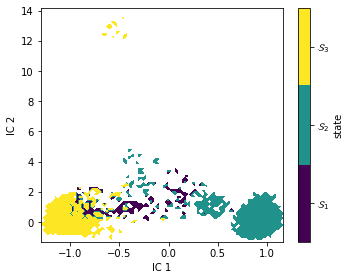

In [57]:
# print sphase space rmsd and orientation

metastable_traj = msm.metastable_assignments[dtrajs_active_concatenated]

fig, ax = plt.subplots(figsize=(5, 4))
_, _, misc = pyemma.plots.plot_state_map(
    *new_tica_concatenated[:, :2].T, metastable_traj, ax=ax)
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
misc['cbar'].set_ticklabels([r'$\mathcal{S}_%d$' % (i + 1)
                             for i in range(nstates)])
fig.tight_layout()

In [63]:
# Stationary distribution
print('state\tπ\t\tG/kT')
for i, s in enumerate(msm.metastable_sets):
    p = msm.pi[s].sum()
    print('{}\t{:f}\t{:f}'.format(i + 1, p, -np.log(p)))
    

state	π		G/kT
1	0.004603	5.381008
2	0.349646	1.050834
3	0.645751	0.437342


## Analysis

### MPFT

In [65]:
# mean first passage times (MFPTs)

mfpt = np.zeros((nstates, nstates))
for i, j in product(range(nstates), repeat=2):
    mfpt[i, j] = msm.mfpt(
        msm.metastable_sets[i],
        msm.metastable_sets[j])

from pandas import DataFrame
print('MFPT / ns:')
MPFT_df = DataFrame(np.round(mfpt, decimals=2), index=range(1, nstates + 1), columns=range(1, nstates + 1))
MPFT_df

MFPT / ns:


,1,2,3
1,0.00,432.25,1098.33
2,856.49,0.00,1326.32
3,2622.45,2426.20,0.00


### Visualization of Macrostate conformations

In [ ]:
### this writes structures of the macrostate to a pdb file ###########

n_pcca_samples = 10

pcca_samples = msm.sample_by_distributions(msm.metastable_distributions, n_pcca_samples)
torsions_source = pyemma.coordinates.source(h5_trajs, features=feat)
outfiles_path = 'output_path'
pyemma.coordinates.save_trajs(
    torsions_source,
    pcca_samples,
    outfiles=[outfiles_path.format(n + 1)
              for n in range(msm.n_metastable)])

# Project the macrostates on rmsd, angle, and position

In [15]:
# load rmsd data, rmsd data is not used for the MSM, just for the visualization of the datapoints
rmsd_dir = 'path_to_rmsd'

torsions_angles_pos_rmsd_data = add_data(h5_trajs,torsions_angles_pos_data,rmsd_dir)

all_rmsd_data = [entry[:,42] for entry in torsions_angles_pos_rmsd_data]
all_angle_data = [entry[:,40] for entry in torsions_angles_pos_rmsd_data]
all_pos_data = [entry[:,41] for entry in torsions_angles_pos_rmsd_data]

No handles with labels found to put in legend.
No handles with labels found to put in legend.


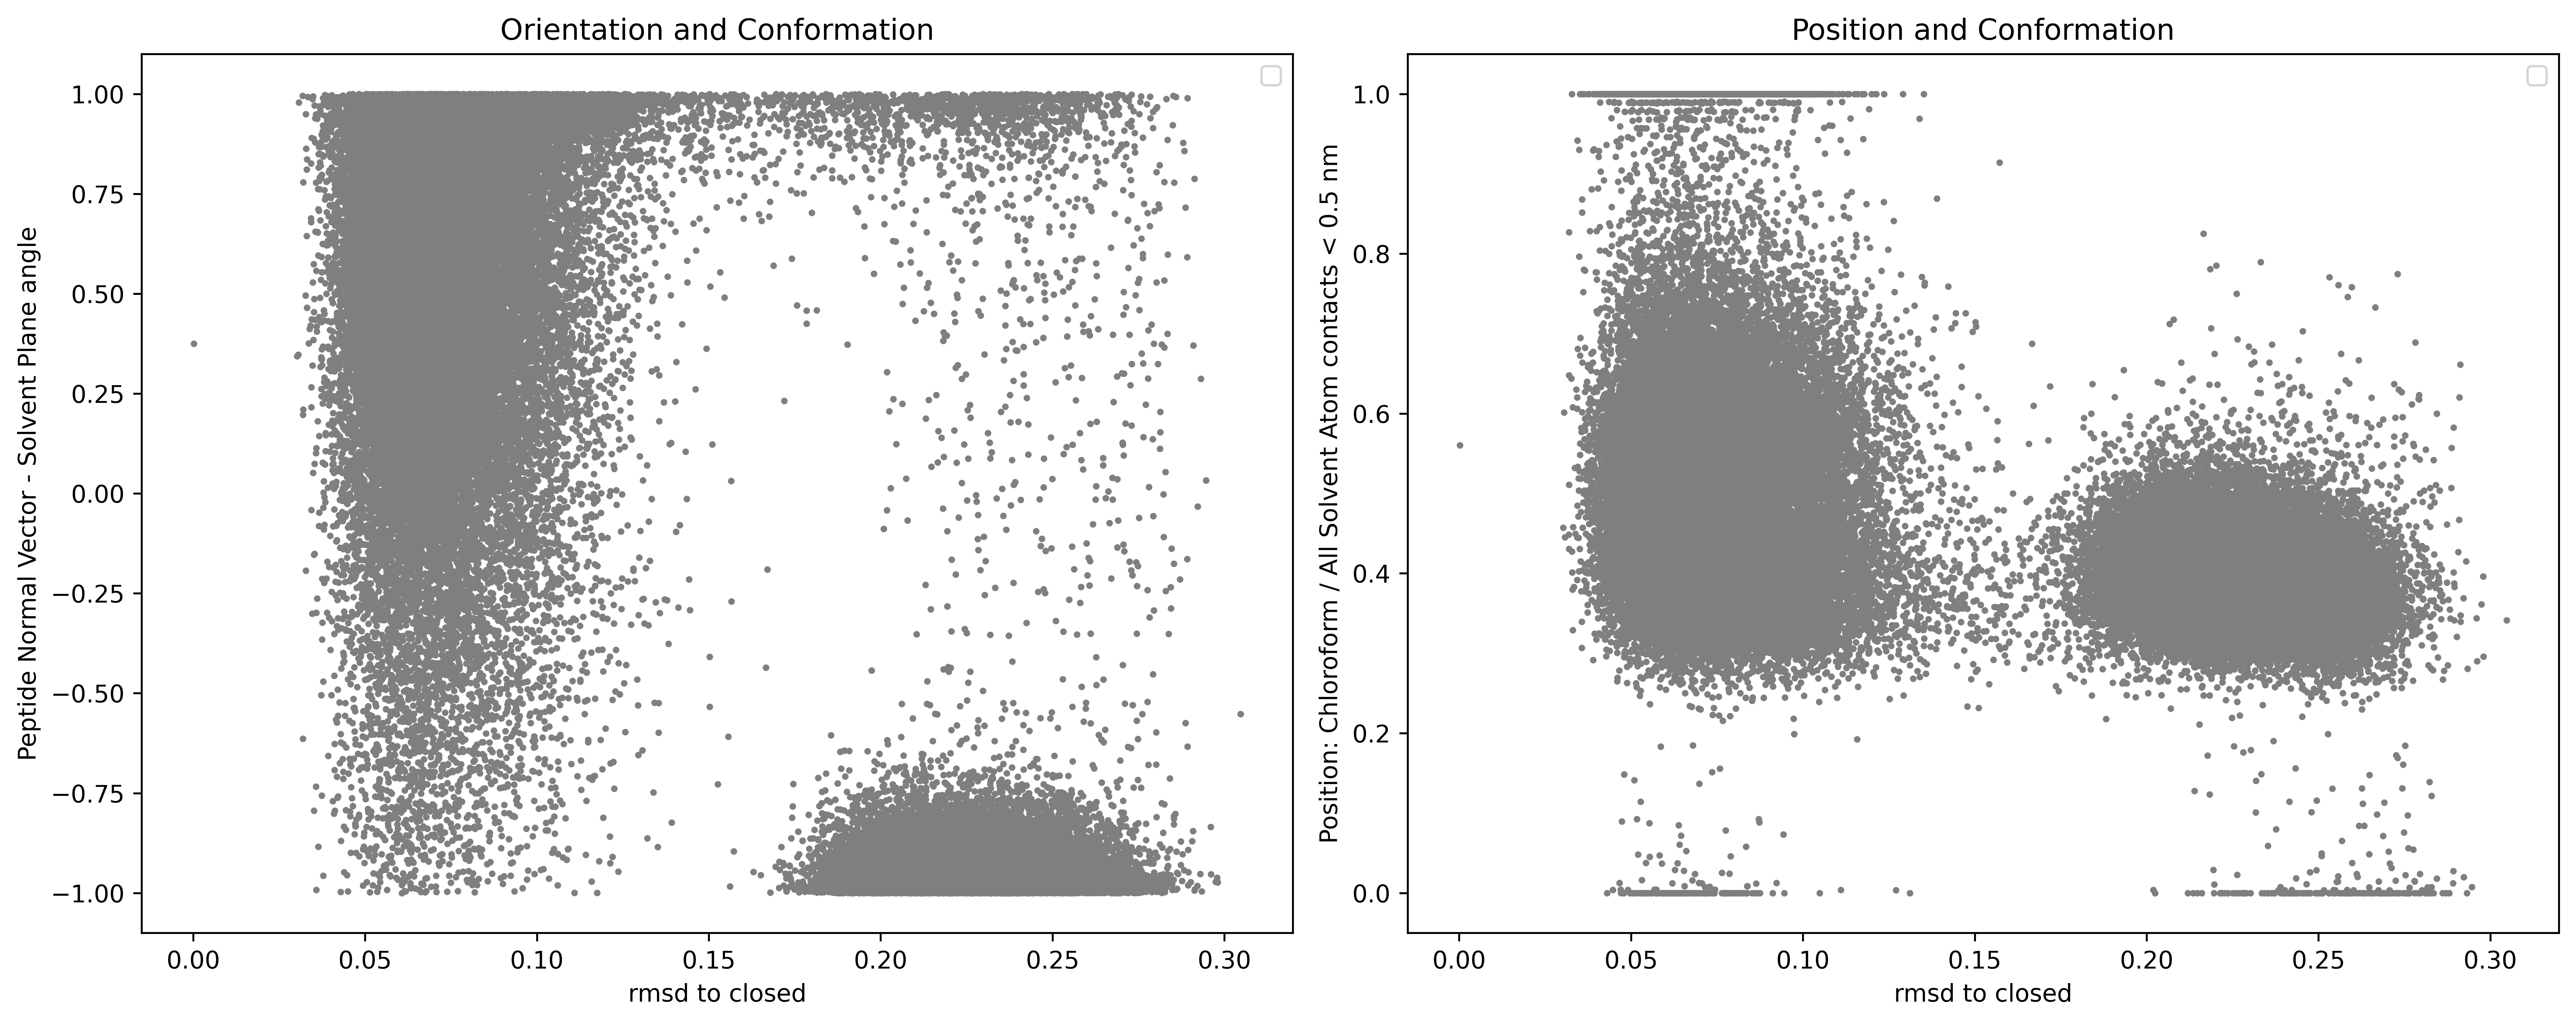

In [17]:
# Make figure

# SETUP
fig = plt.figure(figsize=(14.9,6.5), dpi=600)
gs = fig.add_gridspec(2,2)

# Angle
ax1 = fig.add_subplot(gs[0:2:1,0:1:1])
ax1.scatter(np.concatenate(all_rmsd_data),np.concatenate(all_angle_data), s=3, c="tab:grey")
ax1.set(title="Orientation and Conformation", xlabel="rmsd to closed",ylabel="Peptide Normal Vector - Solvent Plane angle")
ax1.legend()

# Orientation
ax2 = fig.add_subplot(gs[0:2:1,1:2:1])
ax2.scatter(np.concatenate(all_rmsd_data),np.concatenate(all_pos_data), s=3, c="tab:grey")
ax2.set(title="Position and Conformation", xlabel="rmsd to closed",ylabel="Position: Chloroform / All Solvent Atom contacts < 0.5 nm")
ax2.legend()

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

## Color the different macrostates

In [ ]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

#everything below 0.02 is white 
cdict_red = {'red':   [[0.0,  1.0, 1.0],
                   [0.02,  1.0, 1.0],
                   [0.5,  1.0, 1.0],
                   [1.0,  1.0, 1.0]],
         'green': [[0.0,  1.0, 1.0],
                   [0.02,  1.0, 1.0],
                   [0.02,  0.8, 0.8],
                   [0.6,  0.0, 0.0],
                   [1.0,  0.0, 0.0]],
         'blue':  [[0.0,  1.0, 1.0],
                   [0.02,  1.0, 1.0],
                   [0.02,  0.8, 0.8],
                   [0.6,  0.0, 0.0],
                   [1.0,  0.0, 0.0]]}

newcmp_red = LinearSegmentedColormap('testCmap', segmentdata=cdict_red, N=256)

cdict_blue = {'blue':   [[0.0,  1.0, 1.0],
                   [0.02,  1.0, 1.0],
                   [0.5,  1.0, 1.0],
                   [1.0,  1.0, 1.0]],
         'green': [[0.0,  1.0, 1.0],
                   [0.02,  1.0, 1.0],
                   [0.02,  0.8, 0.8],
                   [0.6,  0.0, 0.0],
                   [1.0,  0.0, 0.0]],
         'red':  [[0.0,  1.0, 1.0],
                   [0.02,  1.0, 1.0],
                   [0.02,  0.8, 0.8],
                   [0.6,  0.0, 0.0],
                   [1.0,  0.0, 0.0]]}

newcmp_blue = LinearSegmentedColormap('testCmap', segmentdata=cdict_blue, N=256)

cdict_orange = {'red':   [[0.0,  1.0, 1.0],
                   [0.02,  1.0, 1.0],
                   [0.02,  0.99, 0.99],
                   [0.7,  0.8, 0.8],
                   [1.0,  0.8, 0.8]],
         'blue':   [[0.0,  1.0, 1.0],
                   [0.02,  1.0, 1.0],
                   [0.02,  0.51, 0.51],
                   [0.7,  0.16, 0.16],
                   [1.0,  0.16, 0.16]],
         'green':  [[0.0,  1.0, 1.0],
                   [0.02,  1.0, 1.0],
                   [0.02,  0.77, 0.77],
                   [0.7,  0.46, 0.46],
                   [1.0,  0.46, 0.46]]}

newcmp_orange = LinearSegmentedColormap('testCmap', segmentdata=cdict_orange, N=256)

In [91]:
def dimension_values(nstates,dimension):
    dimension_values = []
    for state in range(nstates):
        a = dimension_values_by_state(state,dimension)
        dimension_values.append(a)
    return(np.array(dimension_values,dtype=object))

def dimension_values_by_state(state,dimension):
    dimension_values_by_state = []
    for frame in range(len(macrostate_frames[state])):
        a = torsions_angles_pos_rmsd_data[int(macrostate_frames[state][frame][0])][int(macrostate_frames[state][frame][1])][dimension]
        dimension_values_by_state.append(a)
    return(np.array(dimension_values_by_state))


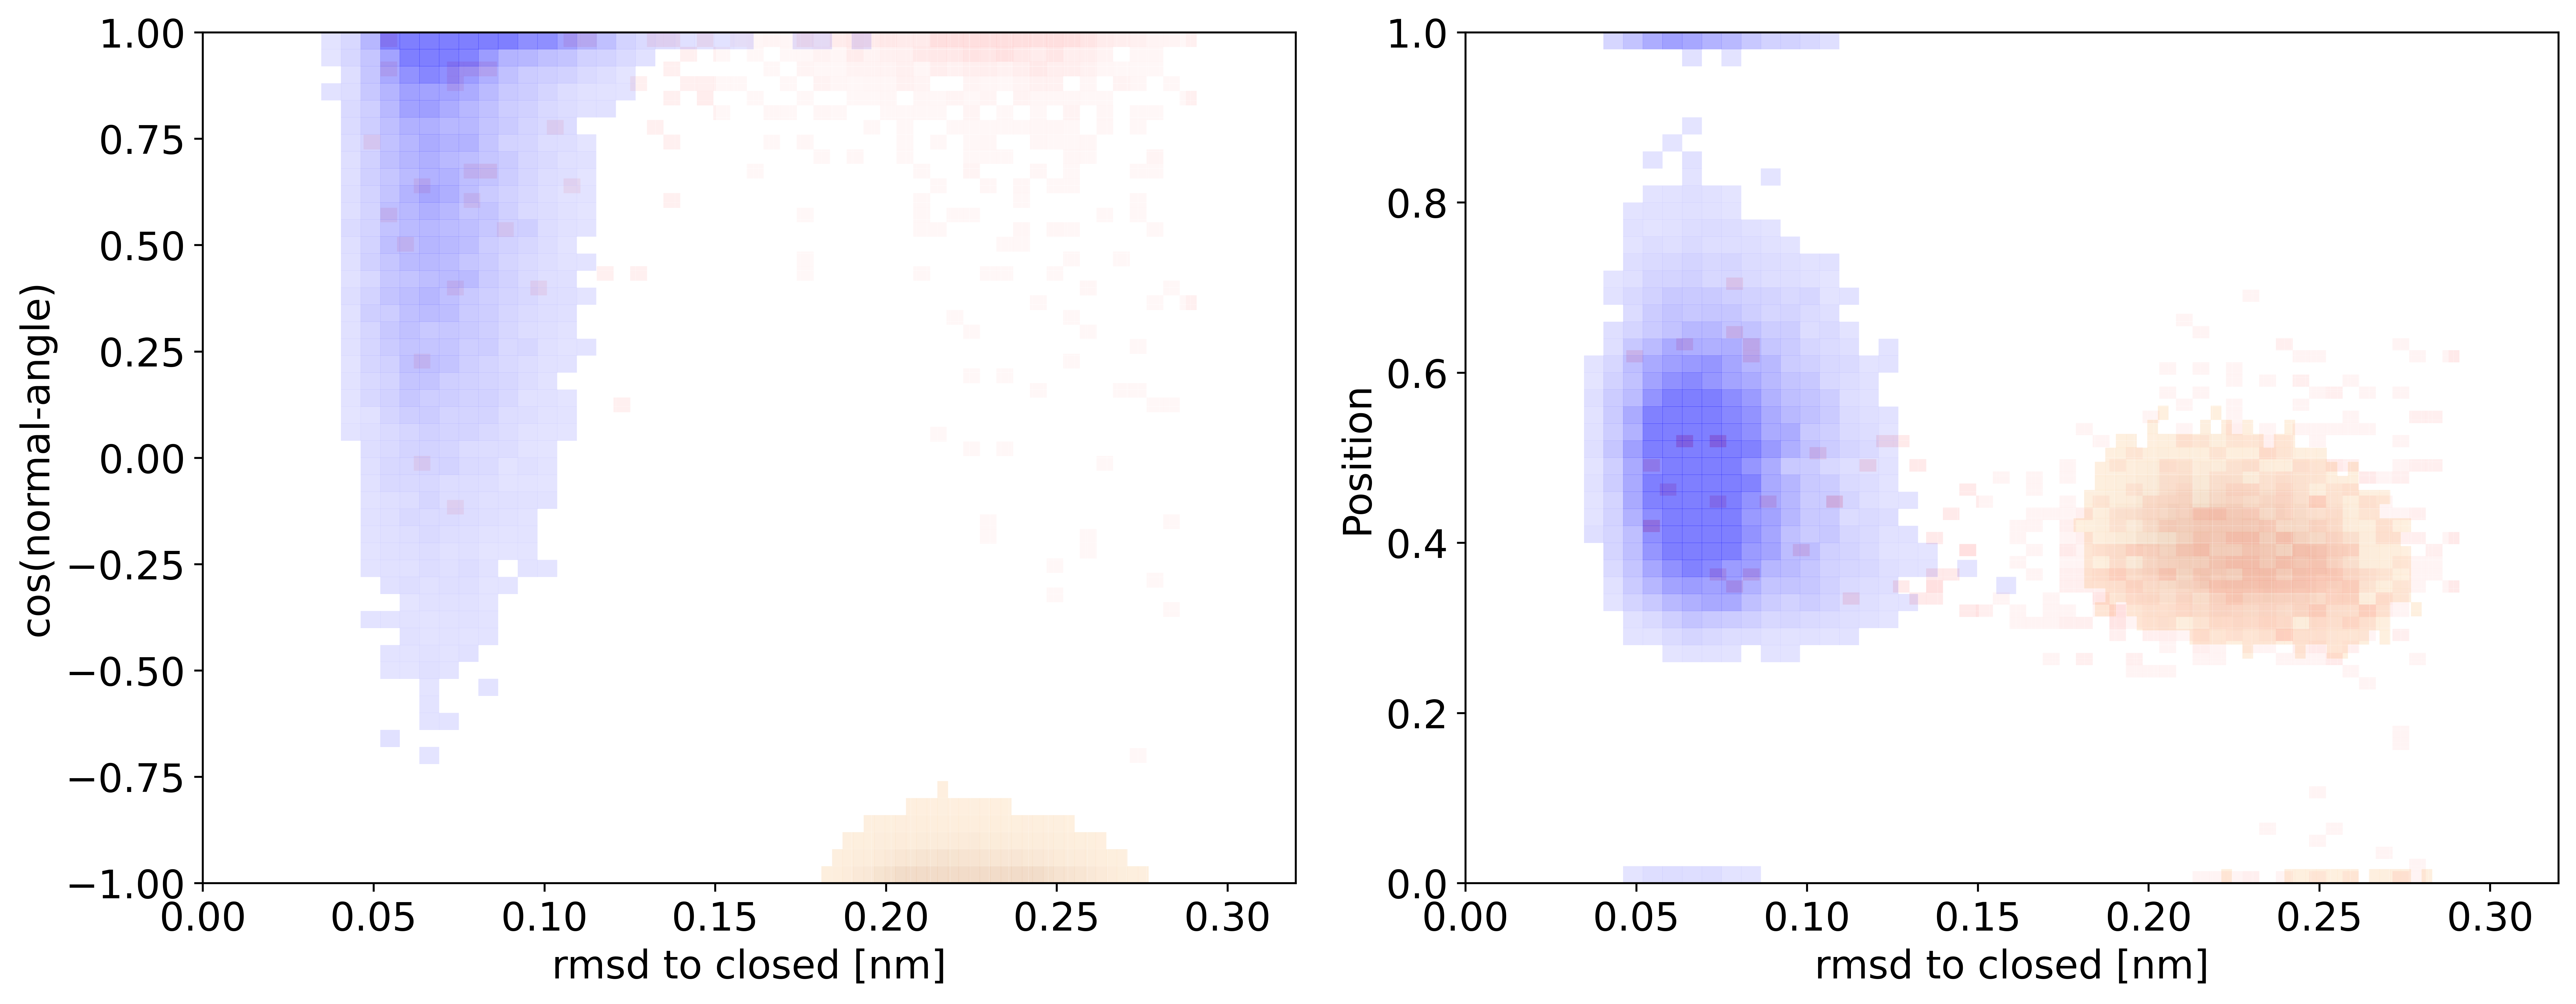

In [150]:
# plot for paper
bin_size = 50

#define own color gradient 
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

fig = plt.figure(figsize=(14.9,6.5), dpi=600)
gs = fig.add_gridspec(2,2)

# get the angle, position and rmsd data

rmsd_by_state = dimension_values(nstates,42)
angles_by_state = dimension_values(nstates,40)
pos_by_state = dimension_values(nstates,41)

# Angle
ax1 = fig.add_subplot(gs[0:2:1,0:1:1])

ax1.hist2d(rmsd_by_state[0],angles_by_state[0], bins=(bin_size, bin_size), cmap=newcmp_red, label="State 1", alpha=0.5)
ax1.hist2d(rmsd_by_state[2],angles_by_state[2], bins=(bin_size, bin_size), cmap=newcmp_orange, label="State 3", alpha=0.5)
ax1.hist2d(rmsd_by_state[1],angles_by_state[1], bins=(bin_size, bin_size), cmap=newcmp_blue, label="State 2", alpha=0.5)
ax1.set_xlim(0,0.32)
ax1.set_ylim(-1,1)
ax1.set(xlabel="rmsd to closed [nm]",ylabel=r"orientation [cos(\alpha)]")


# Orientation
ax2 = fig.add_subplot(gs[0:2:1,1:2:1])

ax2.hist2d(rmsd_by_state[0],pos_by_state[0], bins=(bin_size, bin_size), cmap=newcmp_red, label="State 1", alpha=0.5)
ax2.hist2d(rmsd_by_state[2],pos_by_state[2], bins=(bin_size, bin_size), cmap=newcmp_orange, label="State 3", alpha=0.5)
ax2.hist2d(rmsd_by_state[1],pos_by_state[1], bins=(bin_size, bin_size), cmap=newcmp_blue, label="State 2", alpha=0.5)
ax2.set_xlim(0,0.32)
ax2.set_ylim(0,1)
ax2.set(xlabel="rmsd to closed [nm]",ylabel="Position")


fig.tight_layout(rect=[0, 0.03, 1, 0.95])